<h1 style="margin-bottom: 5px"><strong>Brazilian hedge funds walkthrough</strong></h1>
<span style="font-size: 18px; font-weight: 400">Evaluating and backtesting a dynamic investment strategy</span>
<br>
<span style="font-size: 18px; font-weight: 400">Project #2 - Risk-parity portfolio analysis</span>

<h1>Introduction</h1>

<p>
  The Brazilian hedge funds have their own index, created by the self-regulatory agency of Brazilian financial institutions, <strong>Anbima</strong>, called the IHFA: <a href="https://www.anbima.com.br/pt_br/informar/precos-e-indices/indices/ihfa.htm" target="_blank">Anbima Hedge Fund Index</a>. In truth, the index is composed of a Brazilian fund class called "Multimarkets," the closest equivalent to hedge funds in the US. They typically exhibit a volatility exposure of five to eight percent and charge the standard "two and twenty" fee on returns above the CDI, the Brazilian interbank interest rate. Approximately seventy to eighty percent of their assets under management are allocated in Brazilian government bonds and overnight repo transactions, which gives them a similarity to capital-protected structured notes.
</p>

<p>
  These funds typically trade these assets:
</p>

<ol>
  <li>
    <strong>Brazilian Corporate Bonds</strong>
    <p>
      Brazilian corporate bonds do not have strong liquidity in the secondary market, nor is there an ETF available. However, some multimarket funds usually trade them. Therefore, I represent them using the Brazilian corporate bonds index created by ANBIMA, called IDA. The "IDA - General" index, which provides the performance of all types of corporate bonds—both indexed and fixed-rate—will be used.
    </p>
  </li>
  <br>
  <li>
    <strong>Brazilian Floating Rate Bonds</strong>
    <p>
      Brazilian interest rates are historically very high. Inflation and fiscal pressures contribute to these high rates. In the Brazilian scenario, the floating rate government bond with the shortest maturity is considered the safest asset. Asset managers acquire them to hedge the fund's risk exposures relative to their trading strategies. These bonds are known as Treasury Financial Letters (LFTs), and ANBIMA offers an index composed of active LFTs called IMA - S.
    </p>
  </li>
  <br>
  <li>
    <strong>Brazilian Inflation-Linked Bonds</strong>
    <p>
      Brazilian government inflation-linked bonds offer attractive real interest payments and represent a significant portion of the country's total debt. There are two types: with or without a coupon. They are known as NTN-B ("National Treasury Notes, Class B"). ANBIMA also provides an index for them, the IMA-B, which is used in this study to represent these bonds. They have strong market liquidity, although the ETF tracking the index does not.
    </p>
  </li>
  <br>
  <li>
    <strong>Brazilian Stocks</strong>
    <p>
      The Brazilian stock market is represented by the Bovespa Index. "Bovespa" refers to the São Paulo Stock Exchange, located in Brazil's financial center. There are around 400 publicly listed stocks in Brazil, but only about 130 of them have sufficient liquidity. The Ibovespa selects approximately 80 stocks from these to compose the index. The main ETF tracking the index is BOVA11 (listed as "BOVA11.SA" on Yahoo Finance).
    </p>
  </li>
  <br>
  <li>
    <strong>Fixed Rate Brazilian Bonds</strong>
    <p>
      Brazil has a long history of high interest and inflation rates. Despite the high rates, the cyclical nature of the Brazilian economy often presents attractive opportunities to short Brazilian interest rates, making them relevant for Brazilian multimarket macro funds. Unlike the US and Europe, the Brazilian economy does not have the same level of maturity, so the Brazilian central bank does not issue long-term fixed-rate bonds—only inflation-linked bonds with coupons. Although there is no highly liquid ETF for fixed-rate bonds, these bonds are actively traded. To represent them, this analysis uses the ANBIMA fixed-rate bonds index, IFR - M.
    </p>
  </li>
  <br>
  <li>
    <strong>US Stocks</strong>
    <p>
      The Brazilian broad market index has not performed as well historically as the US stock market, nor does it include global blue-chip stocks like those in the S&P 500. With an increasingly open market, some Brazilian multimarket managers are now picking global blue-chip stocks from the US market. This strategy is represented by the S&P 500 in our analysis.
    </p>
  </li>
  <br>
  <li>
    <strong>Commodities</strong>
    <p>
      The Brazilian economy is strongly based on the primary sector. Agribusiness alone accounts for one-third of Brazil's GDP, with soybean, corn, beef, and coffee being notable highlights. Energy and mineral commodities also play important roles; Brazil’s largest publicly listed companies, Petrobras and Vale, focus on crude oil and iron ore, respectively. In the futures market, the role of commodities is less pronounced, as Brazilian producers are only now starting to hedge their harvests. However, some asset managers are actively seeking alpha in these markets. In this analysis, commodities are represented by the most important US ETF, GSG, which replicates the Goldman Sachs Commodity Index (GSCI).
    </p>
  </li>
  <br>
  <li>
    <strong>US Dollars</strong>
    <p>
      US Dollars represent one of the most important allocations in Brazilian multimarket funds. The Brazilian stock market has a strong negative correlation with the USD/BRL exchange rate, and the Brazilian real has depreciated by approximately 7.3% year over year relative to the US Dollar. This makes the US Dollar crucial for hedging and exploring alpha opportunities. A phenomenon known as the "dollar smile" occurs when the US economy significantly under- or outperforms its peers, causing the dollar to strengthen relative to other currencies. This, in turn, makes the Brazilian currency and stock market globally significant in certain scenarios and attracts international investors. A few large flows of foreign capital can have a strong effect on Brazilian asset prices.
    </p>
  </li>
  <br>
  <li>
    <strong>Brazilian Interbank Deposit Interest Rates</strong>
    <p>
      As mentioned earlier, one of the most important exposures, both in terms of allocation size and management focus, is to Brazilian interest rates. This asset class offers interesting volatility and numerous opportunities for more sophisticated alpha strategies, famously exploited by renowned Brazilian asset managers on Faria Lima. They traditionally captured these opportunities by trading "DI Futures," which track Brazilian interbank deposit interest rates and usually trade about 10 bps below the SELIC, the Brazilian equivalent of the Fed rate. In this analysis, this exposure is represented by an ANBIMA index that reflects the constant two-year maturity interest rate, called IDkA.
    </p>
  </li>
</ol>

<h2>Analysis</h2>
<p>
This analysis aims to identify the dynamic exposures of multimarket funds to these assets using Kalman betas. According to the underlying thesis, these betas provide a more accurate view of the alpha generated than the CDI, which is their benchmark. The alpha delivered during the analyzed period will be calculated, and then a passive portfolio will be constructed using risk parity based on smoothed expanding volatility. In the end, the strategies will be evaluated based on key financial metrics such as annualized return, volatility, and the Sharpe ratio.
</p>

<h2>Useful libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
import json
from functools import reduce
from scipy.stats import norm

<h2>Required data</h2>
<p>Some of the required datasets are not available on Yahoo Finance. The datasets that are available there will be downloaded through the API. The unavailable datasets were collected from the internet and are available as CSV files.</p>

<strong>Required data and its sources</strong>
<table>
    <tr style="background-color: rgba(0, 0, 0, 0.15)">
        <td><strong>ID</strong></td>
        <td><strong>Description</strong></td>
        <td><strong>Symbol</strong></td>
        <td><strong>Source</strong></td>
    </tr>
    <tr>
        <td>01</td>
        <td>US Dollar</td>
        <td>USDBRL=X</td>
        <td>Yahoo Finance</td>
    </tr>
    <tr>
        <td>02</td>
        <td>Ibovespa</td>
        <td>BOVA11.SA</td>
        <td>Yahoo Finance</td>
    </tr>
    <tr>
        <td>03</td>
        <td>S&P 500</td>
        <td>SPY</td>
        <td>Yahoo Finance</td>
    </tr>
    <tr>
        <td>04</td>
        <td>Goldman Sachs Commodity Index</td>
        <td>GSG</td>
        <td>Yahoo Finance</td>
    </tr>
    <tr>
        <td>05</td>
        <td>Brazilian hedge fund index</td>
        <td>IHFA</td>
        <td>Anbima</td>
    </tr>
    <tr>
        <td>06</td>
        <td>Brazilian general corporate bonds index</td>
        <td>IDA - Geral</td>
        <td>Anbima</td>
    </tr>
    <tr>
        <td>07</td>
        <td>Floating rate government bonds</td>
        <td>IMA - S</td>
        <td>Anbima</td>
    </tr>
    <tr>
        <td>08</td>
        <td>Brazilian inflation-linked bonds</td>
        <td>IMA - B</td>
        <td>Anbima</td>
    </tr>
    <tr>
        <td>09</td>
        <td>Brazilian fixed-rate bonds</td>
        <td>IRF - M</td>
        <td>Anbima</td>
    </tr>
    <tr>
        <td>10</td>
        <td>Brazilian 2y constant maturity bonds</td>
        <td>IDkA 2y</td>
        <td>Anbima</td>
    </tr>
    <tr>
        <td>11</td>
        <td>Brazilian interbank deposit rates</td>
        <td>DI</td>
        <td>B3</td>
    </tr>
</table>

<h2>Yahoo! Finance</h2>

In [2]:
def gettingYahooFinanceData(ticker):
    #
    dataframe = yf.download(
        tickers=[ticker], 
        period='1d', 
        start='2008-07-11', 
        end='2025-03-21', 
        auto_adjust=True
    )
    return dataframe

In [3]:
def preProcessingYahooFinanceData(dataframe, asset_name):
    # Pre-processing.
    dataframe.columns = dataframe.columns.get_level_values(0)
    dataframe = pd.DataFrame(dataframe['Close'])
    dataframe[asset_name] = dataframe['Close'].pct_change()
    dataframe.drop(columns=['Close'], inplace=True)
    dataframe = dataframe[1:]
    return dataframe

In [4]:
def getAssetDataFromYahooFinance(ticker, asset_name):
    # Getting data.
    dataframe = gettingYahooFinanceData(ticker)
    # Pre-processing.
    dataframe = preProcessingYahooFinanceData(dataframe, asset_name)
    # Save dataset.
    path = 'data/' + asset_name + '.csv'
    # dataframe.to_csv(path)
    #
    return dataframe

In [5]:
def getMultipleAssetDataFromYahooFinance(asset_dict):
    #
    data = []
    #
    for asset in asset_dict:
        ticker = asset['ticker']
        asset_name = asset['asset_name']
        asset_data = getAssetDataFromYahooFinance(ticker, asset_name)
        data.append(asset_data)
    #
    # data = pd.DataFrame(data) 
    #
    return data

<h2>Anbima</h2>

In [6]:
def getAnbimaData(json_path):
    with open(json_path, 'r', encoding='utf-8') as json_file:
        json_data = json.load(json_file)
    
    registers = []

    for item in json_data["historico"]:
        reference_date = item["data_referencia"]
        for benchmark in item["benchmarks"]:
            registers.append({
                "Date": reference_date,
                "Asset": benchmark["nome"],
                "Return": benchmark["variacao"]
            })

    dataframe = pd.DataFrame(registers)
    return dataframe

In [7]:
def getAnbimaDataForAllIndexes():
    json_1 = 'data/ihfa-ida-idka2y.json'
    json_2 = 'data/irfm-imab-imas.json'
    ihfa_ida_idka2y = getAnbimaData(json_1)
    irfm_imab_imas = getAnbimaData(json_2)
    anbima_data = pd.concat([ihfa_ida_idka2y, irfm_imab_imas])
    return anbima_data

In [8]:
def formatsAnbimaData(anbima_data):
    formatted_anbima_data = anbima_data.pivot(index='Date', columns='Asset', values='Return').dropna()
    formatted_anbima_data = formatted_anbima_data.add(100).pct_change()
    formatted_anbima_data = formatted_anbima_data[1:]
    return formatted_anbima_data

In [9]:
def returnAnbimaDataPreProcessed():
    anbima_data = getAnbimaDataForAllIndexes()
    formatted_anbima_data = formatsAnbimaData(anbima_data)
    # formatted_anbima_data.to_csv('data/anbima_indexes.csv')
    return formatted_anbima_data
    

<h2>B3</h2>

In [10]:
def retornaDataframeCDI():
    cdi_df = pd.read_csv('data/serie_cdi.csv', sep='\t')
    cdi_df['CDI'] = cdi_df['Fator Diário'].str.strip().str.replace(',', '.').astype(float)
    cdi_df.drop(
        columns=['Número Operações', 'Volume', 'Média', 'Fator Diário', 'Mínima', 'Máxima', 'Moda', 'Desvio Padrão', 'Taxa SELIC'], 
        inplace=True
        )
    cdi_df['Data'] = pd.to_datetime(cdi_df['Data'], dayfirst=True)
    cdi_df['Data'] = cdi_df['Data'].dt.strftime('%Y-%m-%d')
    cdi_df.set_index('Data', inplace=True)
    cdi_df['CDI'] = cdi_df['CDI'] - 1
    #
    # cdi_df.to_csv('data/CDI.csv')
    #
    return cdi_df

<h2>Consolidating into one and unique dataset</h2>

In [11]:
def mergeMultiplosDataframes(lista_dataframes, coluna_chave=None, tipo_join='inner'):
    """
    Faz o merge de múltiplos dataframes com base em uma coluna ou índice, garantindo a padronização das chaves.

    Parâmetros:
    lista_dataframes: list
        Lista contendo os dataframes a serem mesclados.
    coluna_chave: str ou None
        Se None, fará o merge usando o índice dos dataframes.
        Caso contrário, fará o merge usando a coluna especificada.
    tipo_join: str
        Tipo de join a ser realizado ('inner', 'outer', 'left', 'right').

    Retorno:
    DataFrame com todos os dataframes mesclados.
    """

    dfs = []

    for df in lista_dataframes:
        df_copy = df.copy()
        if coluna_chave:
            df_copy[coluna_chave] = pd.to_datetime(df_copy[coluna_chave])
        else:
            df_copy.index = pd.to_datetime(df_copy.index)
        dfs.append(df_copy)

    if coluna_chave:
        dataframe_final = reduce(
            lambda left, right: pd.merge(left, right, on=coluna_chave, how=tipo_join),
            dfs
        )
    else:
        dataframe_final = reduce(
            lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how=tipo_join),
            dfs
        )

    return dataframe_final

<h2>Identifying the dynamic exposures of multimarket funds to these assets using Kalman betas</h2>

In [12]:
def aplicarRestricoes(beta_nao_restrito, ativos_sem_short):
    num_ativos = len(beta_nao_restrito)
    def objetivo(beta):
        return np.sum((beta - beta_nao_restrito) ** 2)
    
    restricao_soma = {'type': 'eq', 'fun': lambda beta: np.sum(beta) - 1}
    restricoes = [restricao_soma]
    for i in range(num_ativos):
        if i in ativos_sem_short:
            restricoes.append({'type': 'ineq', 'fun': lambda beta, i=i: beta[i]})
            restricoes.append({'type': 'ineq', 'fun': lambda beta, i=i: 1 - beta[i]})
    
    resultado = minimize(objetivo, beta_nao_restrito, constraints=restricoes)
    return resultado.x

In [13]:
# Função do filtro de Kalman com restrições
def filtroKalmanComRestricoes(retornos_index, retornos_ativos, ativos_sem_short, variancia_processo, variancia_observacao):
    num_periodos, num_ativos = retornos_ativos.shape
    betas = np.zeros((num_periodos, num_ativos))
    beta_anterior = np.ones(num_ativos) / num_ativos
    cov_beta = np.eye(num_ativos) * 0.1
    identidade = np.eye(num_ativos)

    for t in range(num_periodos):
        beta_previsto = beta_anterior
        cov_prevista = cov_beta + variancia_processo * identidade
        y_t = retornos_index[t]
        x_t = retornos_ativos[t, :]
        inovador = y_t - np.dot(x_t, beta_previsto)
        s_t = np.dot(np.dot(x_t, cov_prevista), x_t.T) + variancia_observacao
        k_t = np.dot(cov_prevista @ x_t.T, 1 / s_t)
        beta_nao_restrito = beta_previsto + k_t * inovador
        cov_beta = cov_prevista - np.outer(k_t, x_t) @ cov_prevista
        beta_restrito = aplicarRestricoes(beta_nao_restrito, ativos_sem_short)
        betas[t, :] = beta_restrito
        beta_anterior = beta_restrito

    return betas

In [14]:
def returnsKalmanBetaExposures(dataframe, fatores):
    # Separando o target (IHFA) e os fatores
    retornos_ativos = dataframe[fatores].values
    retornos_index = dataframe['IHFA'].values
    # Informando quais ativos NÃO podem ser shorteados (exemplo)
    ativos_sem_short = [4, 6, 7, 8]
    # Variâncias do filtro.
    variancia_processo = 0.001
    variancia_observacao = 0.01
    #
    estimated_betas = filtroKalmanComRestricoes(retornos_index, retornos_ativos, ativos_sem_short, variancia_processo, variancia_observacao)
    #
    return estimated_betas

In [15]:
# 
def formatsDynamicKalmanBetasDataframe(estimated_betas, assets_dataframe):
    betas_estimados_df = pd.DataFrame(estimated_betas)
    betas_estimados_df['Data'] = assets_dataframe.index
    betas_estimados_df.set_index('Data', inplace=True)
    betas_estimados_df = betas_estimados_df.rename(columns={
        0: 'USDBRL', 
        1: 'IBOVESPA', 
        2: 'S&P500', 
        3: 'GSCI', 
        4: 'IDA - Geral', 
        5: 'IDkA - Pré 2A', 
        6: 'IMA - B', 
        7: 'IMA - S', 
        8: 'IRF - M'
    })
    return betas_estimados_df

In [16]:
def removingFutureBiasOfEstimatedBetas(estimated_betas):
    estimated_betas_no_bias = estimated_betas.shift(1)
    estimated_betas_no_bias = estimated_betas_no_bias[1:]
    return estimated_betas_no_bias

In [17]:
def getEstimatedBetasNoBiasDataframe(dataframe, factors):
    #
    estimated_betas = returnsKalmanBetaExposures(dataframe, factors)
    estimated_betas_df = formatsDynamicKalmanBetasDataframe(estimated_betas, dataframe)
    #
    estimated_betas_no_bias_df = removingFutureBiasOfEstimatedBetas(estimated_betas_df)
    #
    return estimated_betas_df, estimated_betas_no_bias_df

In [18]:
def getEstimatedReturnsByDynamicBetas(estimated_betas_df, dataframe, factors):
    #
    estimated_returns_list = []
    #
    for date in dataframe.index:
        estimated_return = 0.0
        for factor in factors:
            estimated_return = estimated_return + estimated_betas_df.loc[date][factor] * dataframe.loc[date][factor]
        estimated_returns_list.append([date, estimated_return])
    #    
    estimated_return_df = pd.DataFrame(estimated_returns_list).rename(columns={
        0: 'Date', 
        1: 'estimated_return'
    }).set_index('Date')
    #
    return estimated_return_df

<h2>Creating a risk-parity portfolio</h2>

In [19]:
def getRiskParityWeightsDataframe(expanding_volatility):
    # Calculating risk parity weights inversely proportional to volatility.
    risk_parity_weights = 1 / expanding_volatility
    risk_parity_weights = risk_parity_weights.div(risk_parity_weights.sum(axis=1), axis=0)
    risk_parity_weights_df = pd.DataFrame(risk_parity_weights)
    return risk_parity_weights_df

In [20]:
def getWeightedPortfolioReturns(assets_returns, weights, factors, column_name):
    #
    estimated_returns_list = []
    #
    for date in assets_returns.index:
        estimated_return = 0.0
        for factor in factors:
            estimated_return = estimated_return + weights.loc[date][factor] * assets_returns.loc[date][factor]
        estimated_returns_list.append([date, estimated_return])
    #    
    estimated_return_df = pd.DataFrame(estimated_returns_list).rename(columns={
        0: 'Date', 
        1: column_name
    }).set_index('Date')
    #
    return estimated_return_df

In [21]:
def getAssetsReturnsDataframe(dataframe, factors):
    dataframe = dataframe[1:]
    assets_returns_df = dataframe[factors]
    return assets_returns_df

<h2>Strategies' performance evaluation</h2>

<h3>Dataset preparation</h3>

<h3>Analysis</h3>

<table>
  <thead>
    <tr>
      <th>Metric</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Accumulated return</td>
      <td>Total return over the entire period.</td>
    </tr>
    <tr>
      <td>Annualized return</td>
      <td>Annualized return based on daily compounding.</td>
    </tr>
    <tr>
      <td>Average return per day</td>
      <td>Average return per trade (non-zero return days).</td>
    </tr>
    <tr>
      <td>Win rate</td>
      <td>Win rate: percentage of trades with positive return.</td>
    </tr>
    <tr>
      <td>Max drawdown</td>
      <td>Maximum historical drawdown (worst peak-to-trough decline).</td>
    </tr>
    <tr>
      <td>Expecteded drawdown for 21 business days</td>
      <td>Average maximum drawdown observed in rolling 21-day windows.</td>
    </tr>
    <tr>
      <td>Recovery time in days</td>
      <td>Recovery time: number of days to recover from the maximum drawdown.</td>
    </tr>
    <tr>
      <td>Annualized volatility</td>
      <td>Standard deviation of daily returns (volatility) adjusted to 252 business days.</td>
    </tr>
    <tr>
      <td>Parametric VaR</td>
      <td>Parametric Value at Risk (VaR) at a given confidence level assuming normal distribution.</td>
    </tr>
    <tr>
      <td>Historical VaR</td>
      <td>Historical Value at Risk (VaR) at a given confidence level based on past returns.</td>
    </tr>
    <tr>
      <td>Sharpe index</td>
      <td>Sharpe ratio: excess return over risk-free rate divided by standard deviation.</td>
    </tr>
    <tr>
      <td>Sortino index</td>
      <td>Sortino ratio: excess return over downside deviation (only negative volatility).</td>
    </tr>
    <tr>
      <td>Calmar index</td>
      <td>Calmar ratio: annualized return divided by maximum drawdown.</td>
    </tr>
    <tr>
      <td>Profit factor</td>
      <td>Ratio between total gains and total losses.</td>
    </tr>
    <tr>
      <td>Expected return</td>
      <td>Expected value: average return per trade.</td>
    </tr>
    <tr>
      <td>Average gain</td>
      <td>Average gain on winning trades.</td>
    </tr>
    <tr>
      <td>Average loss</td>
      <td>Average loss on losing trades.</td>
    </tr>
  </tbody>
</table>

In [22]:
def calcularRetornoComposto(serie_de_retornos):
    return (1 + serie_de_retornos).prod() - 1

def calcularRetornoAnual(dataframe):
    dataframe.index = pd.to_datetime(dataframe.index)
    retorno_anual = dataframe.resample('YE').apply(calcularRetornoComposto)
    retorno_anual.index = retorno_anual.index.strftime('%Y')
    return retorno_anual

In [23]:
def plotarGraficoBarrasAgrupadas(dataframe):
    categorias = list(dataframe.columns)
    periodos = list(dataframe.index)

    largura_barra = 0.15
    posicoes = np.arange(len(periodos))

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, categoria in enumerate(categorias):
        deslocamento = (i - len(categorias) / 2) * largura_barra + largura_barra / 2
        valores = dataframe[categoria].values
        ax.bar(posicoes + deslocamento, valores, width=largura_barra, label=categoria)

    ax.set_xticks(posicoes)
    ax.set_xticklabels(periodos, rotation=45)
    ax.set_ylabel('Retorno Anual Composto')
    ax.set_title('Retorno Anual por Estratégia')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [24]:
def calculateTotalReturn(returns):
    return (returns + 1).prod() - 1


def calculateAnnualizedReturn(returns):
    total_return = calculateTotalReturn(returns)
    return (1 + total_return) ** (252 / len(returns)) - 1


def calculateAverageReturnPerTrade(trades):
    return trades.mean() if not trades.empty else 0


def calculateWinRate(trades):
    if len(trades) == 0:
        return 0
    return len(trades[trades > 0]) / len(trades)


def calculateMaxDrawdown(returns):
    growth = (returns + 1).cumprod()
    peak = growth.cummax()
    drawdown = (growth - peak) / peak
    return drawdown.min()


def calculateRecoveryTimeDays(returns):
    growth = (returns + 1).cumprod()
    peak = growth.cummax()
    drawdown = (growth - peak) / peak
    if drawdown.min() >= 0:
        return 0
    min_date = drawdown.idxmin()
    recovery = drawdown[drawdown.index > min_date][drawdown == 0]
    return (recovery.index[0] - min_date).days if not recovery.empty else 0


def calculateAnnualizedVolatility(returns):
    return returns.std() * np.sqrt(252)


def calculateParametricVar(returns, confidence_level):
    return -norm.ppf(1 - confidence_level) * returns.std()


def calculateHistoricalVar(returns, confidence_level):
    return -np.percentile(returns, (1 - confidence_level) * 100)


def calculateExpectedDrawdown21d(returns):
    growth = (returns + 1).cumprod()
    edd_list = []
    for i in range(len(growth) - 21):
        window = growth.iloc[i:i+21]
        peak = window.cummax()
        drawdown = (window - peak) / peak
        edd_list.append(drawdown.min())
    return np.mean(edd_list) if edd_list else 0


def calculateSharpeRatio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    std_dev = returns.std()
    if std_dev == 0 or (excess_return.mean() / std_dev) <= 0:
        return 0
    return excess_return.mean() / std_dev * np.sqrt(252)


def calculateSortinoRatio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    downside = returns[returns < 0].std()
    return excess_return.mean() / downside * np.sqrt(252) if downside > 0 else 0


def calculateCalmarRatio(returns):
    annualized = calculateAnnualizedReturn(returns)
    max_dd = calculateMaxDrawdown(returns)
    return annualized / abs(max_dd) if max_dd < 0 else 0


def calculateProfitFactor(trades):
    gains = trades[trades > 0].sum()
    losses = trades[trades < 0].sum()
    return gains / abs(losses) if abs(losses) > 0 else 0


def calculateExpectedValue(trades):
    return trades.mean()


def calculateAverageGainSize(trades):
    gains = trades[trades > 0]
    return gains.mean() if not gains.empty else 0

def calculateAverageLossSize(trades):
    losses = trades[trades < 0]
    return losses.mean() if not losses.empty else 0

In [25]:
def calculateStrategyMetrics(dataframe, cdi_column_name='CDI', confidence_level=0.95):
    df = dataframe.copy()
    df.index = pd.to_datetime(df.index)

    risk_free_rate = dataframe[cdi_column_name]
    df = df.drop(columns=[cdi_column_name])
    
    strategies = df.columns
    results = {}

    for strategy in strategies:
        returns = df[strategy].dropna()
        trades = returns[returns != 0]

        results[strategy] = {
            'total_return': calculateTotalReturn(returns),
            'annualized_return': calculateAnnualizedReturn(returns),
            'average_return_per_trade': calculateAverageReturnPerTrade(trades),
            'win_rate': calculateWinRate(trades),
            'max_drawdown': calculateMaxDrawdown(returns),
            'recovery_time_days': calculateRecoveryTimeDays(returns),
            'annualized_volatility': calculateAnnualizedVolatility(returns),
            'parametric_var': calculateParametricVar(returns, confidence_level),
            'historical_var': calculateHistoricalVar(returns, confidence_level),
            'expected_drawdown_21d': calculateExpectedDrawdown21d(returns),
            'sharpe_ratio': calculateSharpeRatio(returns, risk_free_rate),
            'sortino_ratio': calculateSortinoRatio(returns, risk_free_rate),
            'calmar_ratio': calculateCalmarRatio(returns),
            'profit_factor': calculateProfitFactor(trades),
            'expected_value': calculateExpectedValue(trades),
            'average_gain_size': calculateAverageGainSize(trades),
            'average_loss_size': calculateAverageLossSize(trades)
        }

    return pd.DataFrame(results)

<h2>Execution<h2>
<h3>Getting required data</h3>

In [26]:
def consolidatingDataset():
    asset_dict = [
        {
            'ticker': 'USDBRL=X', 
            'asset_name': 'USDBRL'
        }, 
        {
            'ticker': 'BOVA11.SA', 
            'asset_name': 'IBOVESPA'
        }, 
        {
            'ticker': 'SPY', 
            'asset_name': 'S&P500'
        },
        {
            'ticker': 'GSG', 
            'asset_name': 'GSCI'
        }
    ]
    asset_data = getMultipleAssetDataFromYahooFinance(asset_dict)
    #
    formatted_anbima_data = returnAnbimaDataPreProcessed()
    #
    cdi = retornaDataframeCDI()
    #
    #
    usdbrl = asset_data[0]
    ibovespa = asset_data[1]
    sp500 = asset_data[2]
    gsci = asset_data[3]
    #
    lista_dataframes = [usdbrl, ibovespa, sp500, gsci, formatted_anbima_data, cdi]
    dataframe = mergeMultiplosDataframes(lista_dataframes)
    return dataframe

In [27]:
dataset = consolidatingDataset()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [28]:
dataset.to_csv('data/dataset.csv')

In [29]:
dataset

,USDBRL,IBOVESPA,S&P500,GSCI,IDA - Geral,IDkA - Pré 2A,IHFA,IMA - B,IMA - S,IRF - M,CDI
2009-07-01,-0.017730,0.002335,0.004133,-0.012646,0.000374,0.002396,0.002342,0.002586,0.000355,0.001358,0.000345
2009-07-02,0.013122,-0.012228,-0.027294,-0.027974,0.000561,0.000552,0.000719,0.001981,0.000355,0.000297,0.000346
2009-07-06,-0.013687,-0.005905,-0.000111,-0.025659,0.000654,0.000551,0.000987,0.001715,0.000310,0.000085,0.000346
2009-07-07,0.021154,-0.024752,-0.019377,-0.018505,0.000747,0.001101,-0.000986,0.000782,0.000355,0.001100,0.000346
2009-07-08,0.018171,-0.004061,-0.000681,-0.028281,0.000933,0.000458,0.000090,0.002603,0.000354,0.000676,0.000343
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14,0.000121,0.026447,0.020656,0.005467,-0.000339,-0.000210,-0.000098,-0.001430,0.000481,0.000146,0.000490
2025-03-17,-0.009985,0.015984,0.007711,0.007703,0.001167,0.002466,0.001034,0.000473,0.000492,0.002332,0.000490
2025-03-18,-0.010893,0.003914,-0.010808,-0.004496,0.001467,0.001602,0.000370,0.003045,0.000502,0.001845,0.000490
2025-03-19,-0.001051,0.010448,0.010891,0.007678,0.000826,0.001028,0.001987,0.002912,0.000480,0.001243,0.000490


In [30]:
factors = ['USDBRL', 'IBOVESPA', 'S&P500', 'GSCI', 'IDA - Geral', 'IDkA - Pré 2A', 'IMA - B', 'IMA - S', 'IRF - M']

dataset.index.name = 'Data'
dataframe = dataset[1:]

estimated_betas_df, estimated_betas_no_bias_df = getEstimatedBetasNoBiasDataframe(dataset, factors)

In [31]:
dataframe

,USDBRL,IBOVESPA,S&P500,GSCI,IDA - Geral,IDkA - Pré 2A,IHFA,IMA - B,IMA - S,IRF - M,CDI
Data,,,,,,,,,,,
2009-07-02,0.013122,-0.012228,-0.027294,-0.027974,0.000561,0.000552,0.000719,0.001981,0.000355,0.000297,0.000346
2009-07-06,-0.013687,-0.005905,-0.000111,-0.025659,0.000654,0.000551,0.000987,0.001715,0.000310,0.000085,0.000346
2009-07-07,0.021154,-0.024752,-0.019377,-0.018505,0.000747,0.001101,-0.000986,0.000782,0.000355,0.001100,0.000346
2009-07-08,0.018171,-0.004061,-0.000681,-0.028281,0.000933,0.000458,0.000090,0.002603,0.000354,0.000676,0.000343
2009-07-10,0.036293,-0.001019,-0.002382,-0.014766,0.001490,0.000824,0.001614,0.001372,0.000354,0.000676,0.000347
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14,0.000121,0.026447,0.020656,0.005467,-0.000339,-0.000210,-0.000098,-0.001430,0.000481,0.000146,0.000490
2025-03-17,-0.009985,0.015984,0.007711,0.007703,0.001167,0.002466,0.001034,0.000473,0.000492,0.002332,0.000490
2025-03-18,-0.010893,0.003914,-0.010808,-0.004496,0.001467,0.001602,0.000370,0.003045,0.000502,0.001845,0.000490


In [32]:
portfolio_returns_df = getWeightedPortfolioReturns(dataset[1:], estimated_betas_no_bias_df, factors, 'no-bias')

In [33]:
smoothed_kalman_weights_df = estimated_betas_no_bias_df.rolling(42).mean().dropna()

Text(0.5, 1.0, 'Smoothed vs. pure Kalman ß')

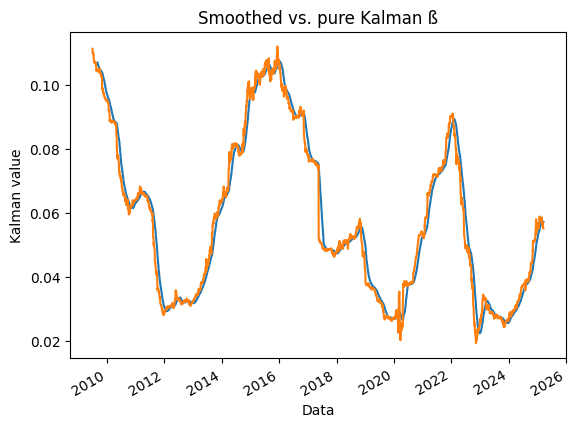

In [34]:
smoothed_kalman_weights_df['S&P500'].plot()
estimated_betas_df['S&P500'].plot()
plt.ylabel('Kalman value')
plt.title('Smoothed vs. pure Kalman ß')

In [35]:
smoothed_portfolio_returns_df = getWeightedPortfolioReturns(dataset[43:], smoothed_kalman_weights_df, factors, 'smoothed_kalman')

Text(0.5, 1.0, 'Smoothed vs. kalman-only')

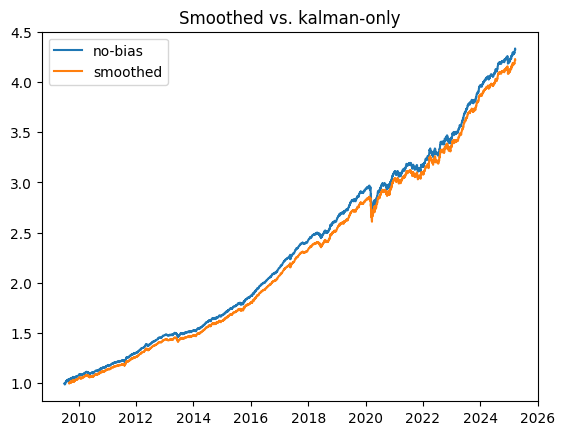

In [36]:
plt.plot(
    portfolio_returns_df['no-bias'].add(1).cumprod(),
    label = 'no-bias'
    )

plt.plot(
    smoothed_portfolio_returns_df['smoothed_kalman'].add(1).cumprod(),
    label = 'smoothed'
    )
plt.legend()
plt.title('Smoothed vs. kalman-only')

In [37]:
def createRiskParityPortfolio(asset_returns, factors, window, name):
    #
    expanding_volatility = asset_returns.expanding().std()
    expanding_volatility = expanding_volatility[window:]
    #
    risk_parity_weights_df = getRiskParityWeightsDataframe(expanding_volatility)
    portfolio_returns = getWeightedPortfolioReturns(asset_returns[window:], risk_parity_weights_df, factors, name)
    #
    return portfolio_returns, risk_parity_weights_df

In [51]:
factors_2 = ['USDBRL',
 'IBOVESPA',
 'S&P500',
 'GSCI',
 'IDA - Geral',
 'IDkA - Pré 2A',
 'IMA - B',
 'IRF - M']

<span>The calculus of an risk-parity portfolio is too "distorced" with the "IMA - S", the brazilian floating rate bonds, that is very similar in returns and low volatility to the CDI. The risk-parity calculus ends to "addict" in these assets, loosing competitiveness. It's not the best thing to do,  but removing them we achieve returns more similar to the exploited by Kalman betas and although a riskier portolio, it continues to have low-risk and similar to their pairs.</span>

In [78]:
rpar_dataset = dataset.copy().drop(columns = ['CDI', 'IHFA', 'IMA - S'])
#
rpar_returns, rpar_weights = createRiskParityPortfolio(
    rpar_dataset, 
    factors_2, 
    42, 
    'risk_parity')

In [79]:
smoothed_rpar_weights_df = rpar_weights.rolling(42).mean().dropna()

In [80]:
smoothed_rpar_weights_df

,USDBRL,IBOVESPA,S&P500,GSCI,IDA - Geral,IDkA - Pré 2A,IMA - B,IRF - M
Data,,,,,,,,
2009-10-30,0.008977,0.009962,0.012102,0.006462,0.589612,0.104327,0.107327,0.161230
2009-11-03,0.008968,0.009914,0.012093,0.006461,0.591143,0.103951,0.106664,0.160806
2009-11-04,0.008961,0.009866,0.012086,0.006460,0.592623,0.103580,0.106031,0.160392
2009-11-05,0.008956,0.009821,0.012077,0.006465,0.594069,0.103208,0.105431,0.159974
2009-11-06,0.008952,0.009777,0.012071,0.006468,0.595488,0.102845,0.104837,0.159562
...,...,...,...,...,...,...,...,...
2025-03-14,0.040131,0.028598,0.040514,0.032280,0.364875,0.194794,0.095873,0.202935
2025-03-17,0.040134,0.028600,0.040516,0.032283,0.364860,0.194791,0.095881,0.202936
2025-03-18,0.040137,0.028602,0.040517,0.032287,0.364844,0.194788,0.095890,0.202936


In [81]:
smoothed_rpar_returns = getWeightedPortfolioReturns(dataset[83:].drop(columns=['IMA - S']), smoothed_rpar_weights_df, factors_2, 'smoothed_rpar')

In [82]:
smoothed_rpar_weights_df

,USDBRL,IBOVESPA,S&P500,GSCI,IDA - Geral,IDkA - Pré 2A,IMA - B,IRF - M
Data,,,,,,,,
2009-10-30,0.008977,0.009962,0.012102,0.006462,0.589612,0.104327,0.107327,0.161230
2009-11-03,0.008968,0.009914,0.012093,0.006461,0.591143,0.103951,0.106664,0.160806
2009-11-04,0.008961,0.009866,0.012086,0.006460,0.592623,0.103580,0.106031,0.160392
2009-11-05,0.008956,0.009821,0.012077,0.006465,0.594069,0.103208,0.105431,0.159974
2009-11-06,0.008952,0.009777,0.012071,0.006468,0.595488,0.102845,0.104837,0.159562
...,...,...,...,...,...,...,...,...
2025-03-14,0.040131,0.028598,0.040514,0.032280,0.364875,0.194794,0.095873,0.202935
2025-03-17,0.040134,0.028600,0.040516,0.032283,0.364860,0.194791,0.095881,0.202936
2025-03-18,0.040137,0.028602,0.040517,0.032287,0.364844,0.194788,0.095890,0.202936


Text(0.5, 1.0, 'Smoothed vs. kalman-only')

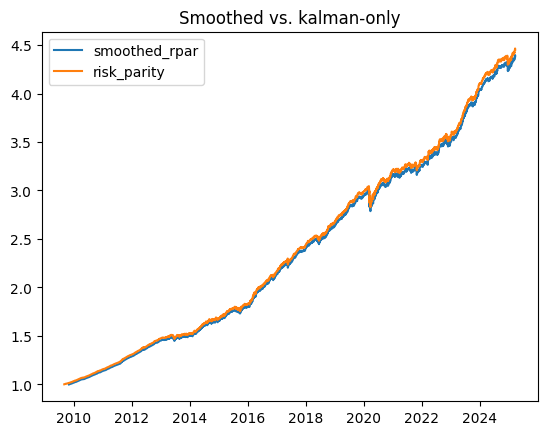

In [83]:
plt.plot(
    smoothed_rpar_returns['smoothed_rpar'].add(1).cumprod(),
    label = 'smoothed_rpar'
    )

plt.plot(
    rpar_returns['risk_parity'].add(1).cumprod(),
    label = 'risk_parity'
    )
plt.legend()
plt.title('Smoothed vs. kalman-only')

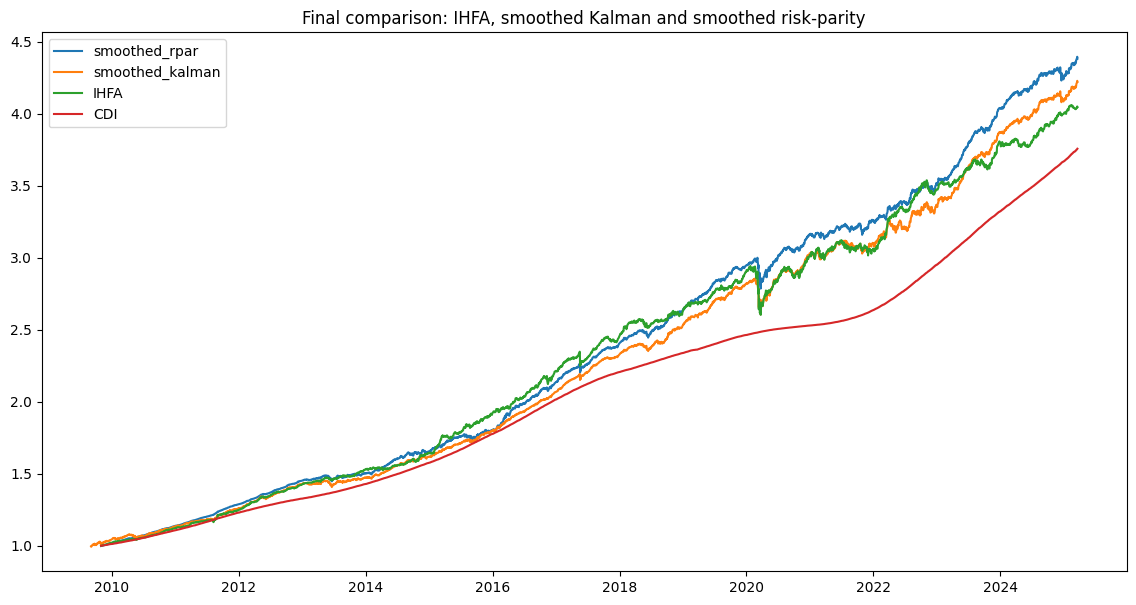

In [100]:
plt.figure(figsize=(14, 7))
#
plt.plot(
    smoothed_rpar_returns['smoothed_rpar'].add(1).cumprod(),
    label = 'smoothed_rpar'
    )

#
plt.plot(
    smoothed_portfolio_returns_df['smoothed_kalman'].add(1).cumprod(),
    label = 'smoothed_kalman'
    )

#
plt.plot(
    dataset[83:]['IHFA'].add(1).cumprod(),
    label = 'IHFA'
    )

#
plt.plot(
    dataset[83:]['CDI'].add(1).cumprod(),
    label = 'CDI'
    )

plt.title('Final comparison: IHFA, smoothed Kalman and smoothed risk-parity')
plt.legend()
plt.show()

<span>It's used the smoothed version to remove unnecessary turnover, that could not be replicated in the real-world because its fees.</span>

In [88]:
strategies_dataset = mergeMultiplosDataframes([
    smoothed_rpar_returns['smoothed_rpar'], 
    smoothed_portfolio_returns_df['smoothed_kalman'], 
    dataset[83:]['IHFA'], 
    dataset[83:]['CDI']
    ])

In [89]:
strategies_dataset

,smoothed_rpar,smoothed_kalman,IHFA,CDI
Date,,,,
2009-10-30,-0.001040,-0.011317,-0.000340,0.000328
2009-11-03,0.001099,0.002876,0.001107,0.000329
2009-11-04,0.000748,0.001471,0.000850,0.000329
2009-11-05,0.000915,0.003807,0.001019,0.000329
2009-11-06,0.000189,-0.002489,0.000255,0.000329
...,...,...,...,...
2025-03-14,0.001502,0.003087,-0.000098,0.000490
2025-03-17,0.002042,0.002405,0.001034,0.000490
2025-03-18,0.000605,0.000451,0.000370,0.000490


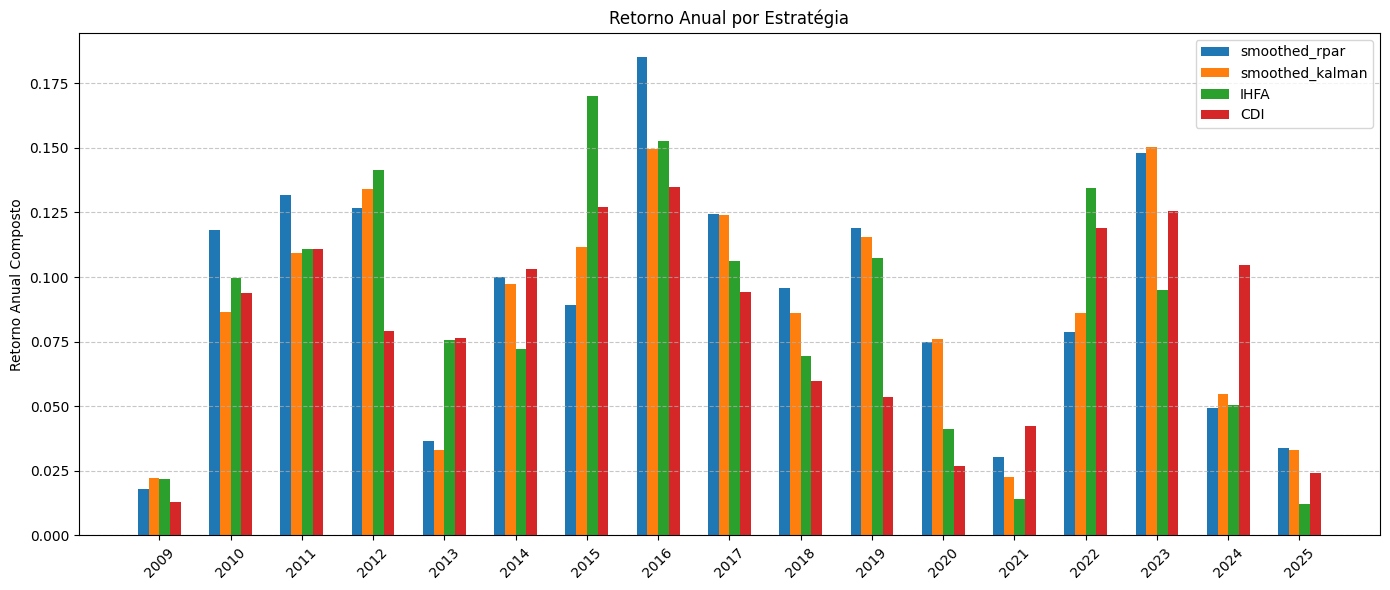

In [90]:
strategies_dataset_annualized = calcularRetornoAnual(strategies_dataset)

plotarGraficoBarrasAgrupadas(strategies_dataset_annualized)

In [91]:
calculateStrategyMetrics(strategies_dataset, cdi_column_name='CDI', confidence_level=0.95)

,smoothed_rpar,smoothed_kalman,IHFA
total_return,3.383900,3.129938,3.046886
annualized_return,0.106384,0.101877,0.100346
average_return_per_trade,0.000403,0.000388,0.000387
win_rate,0.659066,0.615907,0.625000
max_drawdown,-0.071360,-0.087129,-0.115190
recovery_time_days,98.000000,99.000000,247.000000
annualized_volatility,0.032506,0.036330,0.038664
parametric_var,0.003368,0.003764,0.004006
historical_var,0.002567,0.002941,0.003111
expected_drawdown_21d,-0.005001,-0.005967,-0.006581


<h2>Conclusion</h2>
<p><strong>1. Cumulative and Annualized Returns</strong></p>
<ul>
    <li><strong>Smoothed Risk Parity</strong>: Has the highest cumulative return (3.38) and annualized return (~10.6%).</li>
    <li><strong>Smoothed Kalman</strong>: Ranks second with a cumulative return of 3.13 and an annualized return (~10.2%).</li>
    <li><strong>IHFA</strong>: Slightly behind, with a cumulative return of 3.05 and annualized return (~10.0%).</li>
</ul>

<p><strong>2. Volatility and Drawdowns</strong></p>
<ul>
    <li><strong>Annualized Volatility</strong>: Smoothed Risk Parity (3.25%) is lower than Smoothed Kalman (3.63%) and IHFA (3.87%).</li>
    <li><strong>Max Drawdown</strong>: Also smallest for Smoothed Risk Parity (-7.1%), compared with Smoothed Kalman (-8.7%) and IHFA (-11.5%).</li>
    <li><strong>Recovery Time</strong>: Smoothed Risk Parity rebounds the fastest (98 days), just slightly faster than Smoothed Kalman (99 days). IHFA takes significantly longer (247 days).</li>
</ul>

<p><strong>3. Risk-Return Ratios</strong></p>
<ul>
    <li><strong>Sharpe Ratio</strong>: Smoothed Risk Parity (0.34) outperforms Smoothed Kalman (0.20) and IHFA (0.15).</li>
    <li><strong>Sortino Ratio</strong>: Follows the same hierarchy: Smoothed Risk Parity (0.36) &gt; Smoothed Kalman (0.23) &gt; IHFA (0.15).</li>
    <li><strong>Calmar Ratio</strong>: Once again, Smoothed Risk Parity leads (1.49), followed by Smoothed Kalman (1.17) and IHFA (0.87).</li>
</ul>

<p><strong>4. Trade Quality (Win Rate, Profit Factor, etc.)</strong></p>
<ul>
    <li><strong>Win Rate</strong>: Smoothed Risk Parity has the highest win rate (66%), ahead of Smoothed Kalman (62%) and IHFA (63%).</li>
    <li><strong>Profit Factor</strong>: Smoothed Risk Parity (1.83) is also the highest, indicating a stronger ratio of total gains to total losses compared to Smoothed Kalman (1.65) and IHFA (1.64).</li>
    <li><strong>Average Gain / Average Loss</strong>: While Smoothed Kalman and IHFA have somewhat higher average gains, Smoothed Risk Parity’s smaller losses improve its overall risk-return tradeoff.</li>
</ul>

<p>
    Overall, <strong>Smoothed Risk Parity</strong> stands out with stronger risk-adjusted performance, featuring lower volatility, smaller drawdowns, and quicker recovery times. 
    <strong>Smoothed Kalman</strong> delivers returns near Smoothed Risk Parity but exhibits higher drawdowns and somewhat less attractive risk-return metrics. 
    Meanwhile, <strong>IHFA</strong> maintains reasonable profitability but shows a weaker risk-return balance, with higher drawdowns and substantially longer recovery periods.
</p>